# Example 2

This example aims to show the usage of the decisiorama tool for solving MCDA problems. This example is based on the paper of Lahtinen 2007[addlink] 



In [1]:
# import libraries 
import sys
sys.path.insert(0, '..')

import numpy as np

import decisiorama
from decisiorama.pda.preference import Objective, Evaluator
from decisiorama.pda import utility, aggregate, ranker
import decisiorama.utils.random_instance as ri
import itertools
import matplotlib.pyplot as plt

print(decisiorama)

<module 'decisiorama' from '..\\decisiorama\\__init__.py'>


## Definition of the solutions

Here we define the solutions. For each leaf objective, 

In [2]:
# Define the solutions for each of the actions

# Phosporous
p = [ri.Uniform(0.9, 1.1).get,
     ri.Uniform(1.1, 1.3).get,
     ri.Uniform(1.3, 1.7).get,
     ri.Uniform(0.0, 0.0).get,
     ri.Uniform(0.0, 0.0).get,
     ri.Uniform(0.0, 0.0).get,
     ri.Uniform(0.5, 0.6).get,
     ri.Uniform(0.0, 0.0).get,
     ri.Uniform(4.0, 4.8).get,
     ]

# Nitrates
n2 = [ri.Uniform(0.09, 0.11).get,
      ri.Uniform(0.09, 0.11).get,
      ri.Uniform(0.14, 0.17).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.00, 0.00).get,
      ri.Uniform(0.40, 0.48).get,
      ]

# Climate
climate = [ri.Uniform(0.0, 0.0).get,
           ri.Uniform(0.0, 0.0).get,
           ri.Uniform(0.5, 1.5).get,
           ri.Uniform(-1.5, -0.5).get,
           ri.Uniform(0.0, 0.0).get,
           ri.Uniform(0.5, 1.5).get,
           ri.Uniform(0.0, 0.0).get,
           ri.Uniform(0.0, 0.0).get,
           ri.Uniform(-2.5, -1.5).get,
           ]

# Savings
savings = [ri.Uniform(1.8, 2.2).get,
           ri.Uniform(1.8, 2.2).get,
           ri.Uniform(1.8, 2.2).get,
           ri.Uniform(1.8, 2.2).get,
           ri.Uniform(0.9, 1.1).get,
           ri.Uniform(9.0, 11.0).get,
           ri.Uniform(32.0, 40.0).get,
           ri.Uniform(14.0, 18.0).get,
           ri.Uniform(3.5, 4.5).get,
          ]

# Overall
overall = None


In [24]:
n = 100000

obj_p = Objective(
        name = 'p',
        w = 0.25,
        alternatives = p, 
        obj_min = 0.0, 
        obj_max = 4.8, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = False)

obj_n2 = Objective(
        name = 'n2',
        w = 0.25,
        alternatives = n2, 
        obj_min = 0.0, 
        obj_max = 0.48, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = False)

obj_climate = Objective(
        name = 'climate',
        w = 0.25,
        alternatives = climate, 
        obj_min = -2.5, 
        obj_max = 1.5, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = False)

obj_savings = Objective(
        name = 'savings',
        w = 0.25,
        alternatives = savings, 
        obj_min = 0.9, 
        obj_max = 40.0, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = False)

obj_overall = Objective(
        name = 'overall',
        w = 0.25,
        alternatives = overall, 
        obj_min = 0.9, 
        obj_max = 40.0, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = 0.0, 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = False)

In [25]:
# Create the hierarchy of the objectives
obj_overall.add_children(obj_p)
obj_overall.add_children(obj_n2)
obj_overall.add_children(obj_climate) 
obj_overall.add_children(obj_savings)


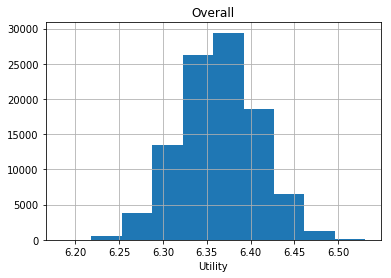

In [26]:
# test the problem solutions
x = [1,1,1,1,1,1,1,1,1]

plt.hist(obj_overall.get_value(x))
plt.grid()
plt.title('Overall')
plt.xlabel('Utility')
plt.show()


In [27]:
# Define the problem limits
costs = [1.0, 1.0, 2.0, 10.0, 8.0, 11.0, 43.0, 23.0, 20.0]
water = [0.03, 0.07, 0.04, 0.015, 0.10, 0.38, 0.15, 0.34, 0.46]
budget_limit = 45.0

# Make function to filter the potentially useful inputs
def filter_inps(inps):
    out = []
    def follow_up(pred, post):
        if post:
            if not pred:
                return False
        return True
        
    def mutual_exclusive(a, b):
        if a and b:
            return False
        return True

    for x in inps:
    
        # follow up action
        if not follow_up(x[3], x[4]):
            continue
        
        # Mutually exclusive actions
        if not mutual_exclusive(x[3], x[5]):
            continue
        
        if not mutual_exclusive(x[6], x[7]):
            continue
        
        if not mutual_exclusive(x[6], x[8]):
            continue
     
        # Budget and water constraints
        budget = np.sum([a for i, a in enumerate(costs) if x[i]]) 
        if budget > budget_limit:
            continue
    
        water_target = 1.0 - np.prod([(1.0 - a) for i, a in enumerate(water) if x[i]])
        if water_target < 0.5:
            continue
        
        out.append(x)
    return out

# get all the results
inp_comb = list(itertools.product([0, 1], repeat=len(x)))

inps = np.array(filter_inps(inp_comb))
res = np.array(list(map(obj_overall.get_value, inps)))


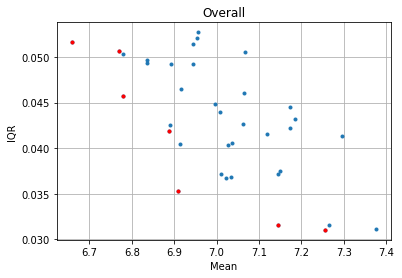

In [22]:
# Evaluate the solutions
ee = Evaluator(inps, res)
ee.add_function(ranker.mean, minimize=True)
ee.add_function(ranker.iqr, minimize=True)

# ee.get_pareto_solutions()
par_sols = ee.get_pareto_solutions()

# Plot the pareto solutions for the overall objective
plt.plot(ranker.mean(res), ranker.iqr(res), '.')
plt.plot(ranker.mean(res)[par_sols], ranker.iqr(res)[par_sols], '.r')
plt.title('Overall')
plt.xlabel('Mean')
plt.ylabel('IQR')
plt.grid()
plt.show()